# Preprocessing 2 
Sample GSM7710088_C3N-00495-T1_CPT0078510004_snRNA_ccRCC 

In [2]:
import scanpy as sc
import tarfile
import gzip
import seaborn as sns
from scipy.io import mmread, mmwrite
import pandas as pd
import numpy as np

Set up paths and extract data.

In [3]:
file_path = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/GSM7710088_C3N-00495-T1_CPT0078510004_snRNA_ccRCC.tar"
output_path = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/RNA_sample_2"

In [4]:
with tarfile.open(file_path, "r") as tar:
    tar.extractall(path=output_path)
    print("Files extracted successfully")

Files extracted successfully


In [5]:
input1_file = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/RNA_sample_2/C3N-00495-T1_CPT0078510004_snRNA_ccRCC/outs/raw_feature_bc_matrix/barcodes.tsv.gz"
input2_file = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/RNA_sample_2/C3N-00495-T1_CPT0078510004_snRNA_ccRCC/outs/raw_feature_bc_matrix/features.tsv.gz"
input3_file = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/RNA_sample_2/C3N-00495-T1_CPT0078510004_snRNA_ccRCC/outs/raw_feature_bc_matrix/matrix.mtx.gz"
output1_file = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/RNA_sample_2/C3N-00495-T1_CPT0078510004_snRNA_ccRCC/outs/raw_feature_bc_matrix/barcodes.tsv"
output2_file = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/RNA_sample_2/C3N-00495-T1_CPT0078510004_snRNA_ccRCC/outs/raw_feature_bc_matrix/features.tsv"
output3_file = "/Users/isabelgiray/Desktop/TUM/3.Semester/Computational_Methods_for_Single_cell_biology/RNA_sample_2/C3N-00495-T1_CPT0078510004_snRNA_ccRCC/outs/raw_feature_bc_matrix/matrix.mtx"

In [6]:
with gzip.open(input1_file, "rt") as gz_file:  
    with open(output1_file, "w") as out_file:
        out_file.write(gz_file.read())

with gzip.open(input2_file, "rt") as gz_file:  
    with open(output2_file, "w") as out_file:
        out_file.write(gz_file.read())
        
with gzip.open(input3_file, "rt") as gz_file:  
    with open(output3_file, "w") as out_file:
        out_file.write(gz_file.read())

In [7]:
matrix = mmread(output3_file).T.tocsc() 


In [8]:
genes = pd.read_csv(output2_file, sep="\t", index_col= None, header=None)[1].values
barcodes_df = pd.read_csv(output1_file, sep="\t", index_col= None, header=None)[0].values
gene_id = pd.read_csv(output2_file, sep="\t", index_col= None, header=None)[0].values

In [9]:
sample_2 = sc.AnnData(
    X = matrix,
)

In [10]:
sample_2.obs_names = barcodes_df
sample_2.var_names = genes
sample_2.var['gene_id'] = gene_id

In [11]:
sample_2

AnnData object with n_obs × n_vars = 940788 × 36601
    var: 'gene_id'

Now we start with the actual preprocessing following the scanpy tutorial.

In [12]:
sample_2.var_names_make_unique()

When a cell has a low number of detected genes, a low count depth and a high fraction of mitochondrial counts it might have a broken membrane which can indicate a dying cellMark mitochondrial genes, as they important for quality analysis. We mark mitochondrial genes:

In [13]:
sample_2.var['mt'] = sample_2.var_names.str.startswith('MT-')

Calculate QC metrics:

In [14]:
sc.pp.calculate_qc_metrics(
    sample_2, qc_vars=['mt'], inplace=True, percent_top=[20],log1p=True
)
sample_2

AnnData object with n_obs × n_vars = 940788 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

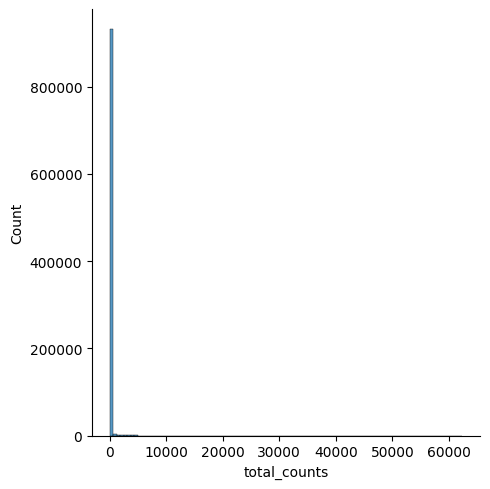

In [14]:
p1 = sns.displot(sample_2.obs["total_counts"], bins=100, kde=False)

-> We have to filter out many low quality cells since the plot shows a high number of cells with zero total counts.

/Users/isabelgiray/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


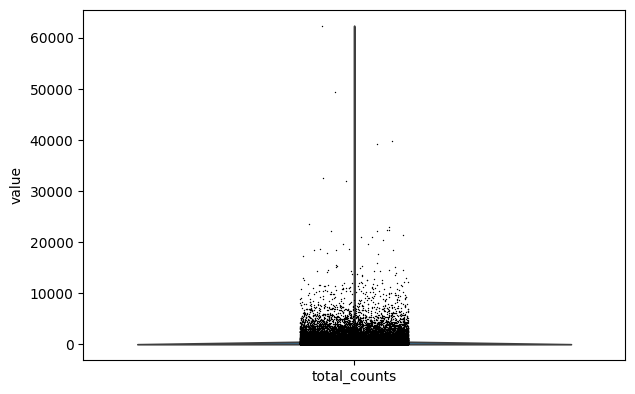

In [15]:
sc.pl.violin(sample_2, 'total_counts')

/Users/isabelgiray/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


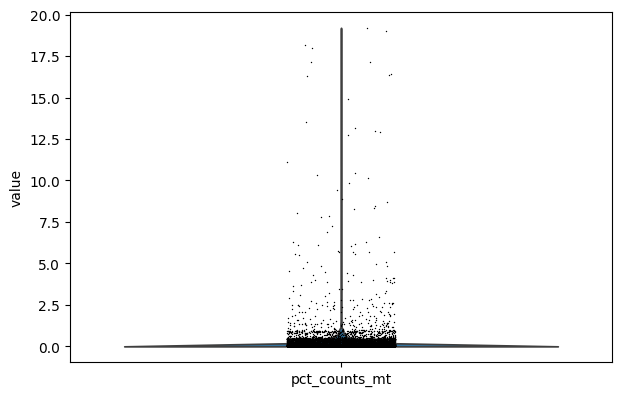

In [154]:
p2 = sc.pl.violin(sample_2, "pct_counts_mt")

pct_counts_mt: represents the percentage of mitochondrial gene expression as a propoortion of total counts for each cell.
The violin is widest near 0, indicating that most cells have very low mitochondrial percentages. These are likely high-quality cells. Some cells have extremely high mitochondrial percentages. Common cut-off for pct_counts_mt is 10–20%. -> 20%

/Users/isabelgiray/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


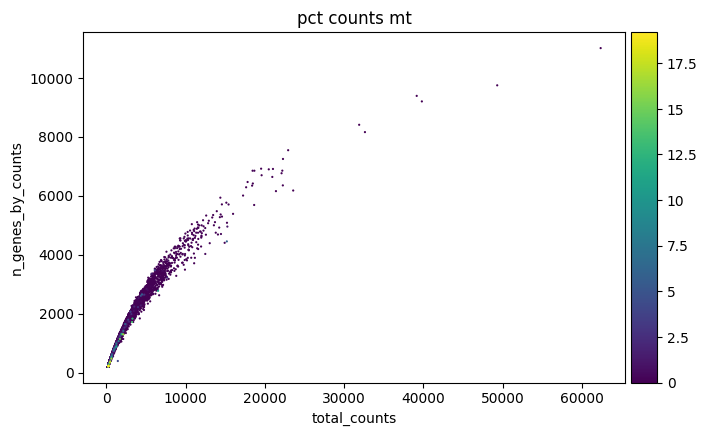

In [153]:
p3 = sc.pl.scatter(sample_2, "total_counts", "n_genes_by_counts", color="pct_counts_mt",size=10)

Low total_counts with high pct_counts_mt: Likely poor-quality cells with few genes expressed, dominated by mitochondrial transcripts.
High total_counts with high pct_counts_mt: Could indicate potential doublets or multiplets (artifacts where multiple cells are captured together).

Like mentioned in the paper we filter out cells that that have less than 200 genes expressed:

In [15]:
sc.pp.filter_cells(sample_2, min_genes=200)

Like in the scanpy tutorials, we filter genes, that are expressed in less than three cells.

In [16]:
sc.pp.filter_genes(sample_2, min_cells=3)

In [17]:
sample_2 = sample_2[sample_2.obs['pct_counts_mt'] < 10, :]

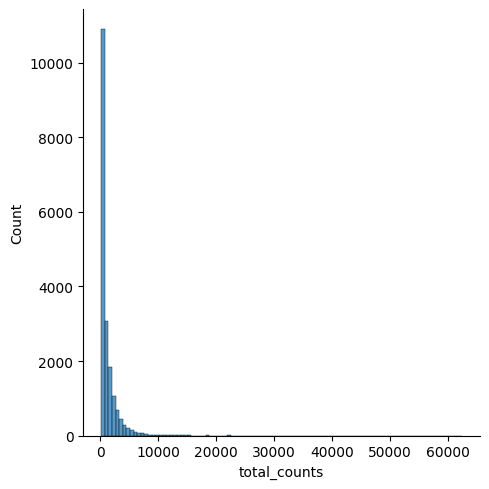

In [152]:
p1 = sns.displot(sample_2.obs["total_counts"], bins=100, kde=False)

Normalization

In [18]:
sc.pp.normalize_total(sample_2)
sc.pp.log1p(sample_2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
sc.pp.highly_variable_genes(sample_2, n_top_genes=2000)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In the context of single-cell RNA sequencing (scRNA-seq), highly variable genes are important because they can help differentiate cells from one another based on their gene expression profiles.

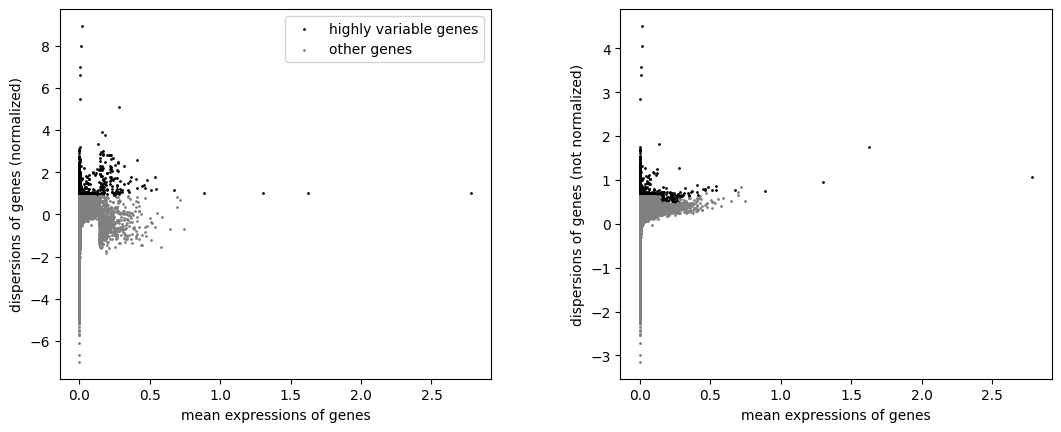

In [20]:
sc.pl.highly_variable_genes(sample_2)

In [21]:
sample_2 = sample_2[:, sample_2.var.highly_variable]

In [22]:
sample_2

View of AnnData object with n_obs × n_vars = 19118 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

/Users/isabelgiray/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


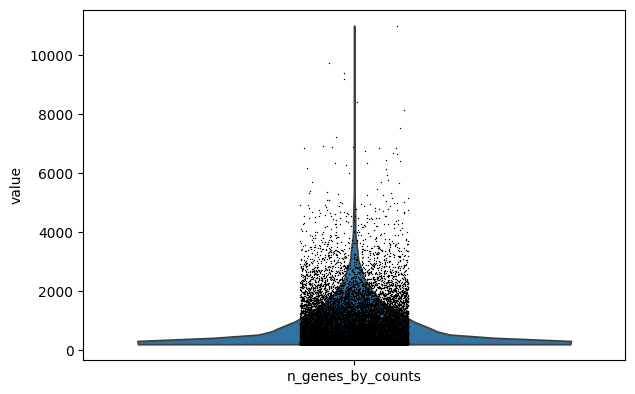

In [155]:
p2 = sc.pl.violin(sample_2, "n_genes_by_counts")

Dimensionality reduction

In [115]:
sc.tl.pca(sample_2)

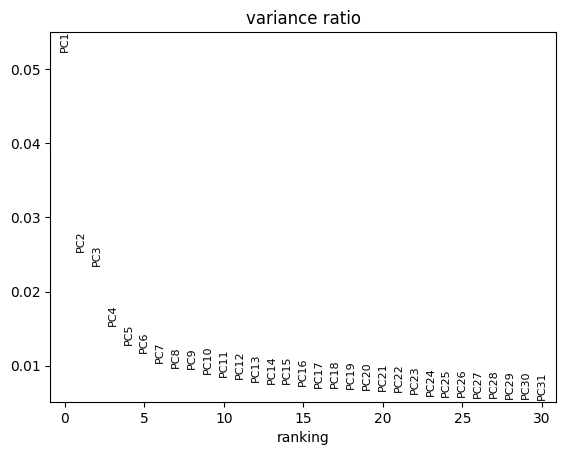

In [89]:
sc.pl.pca_variance_ratio(sample_2)

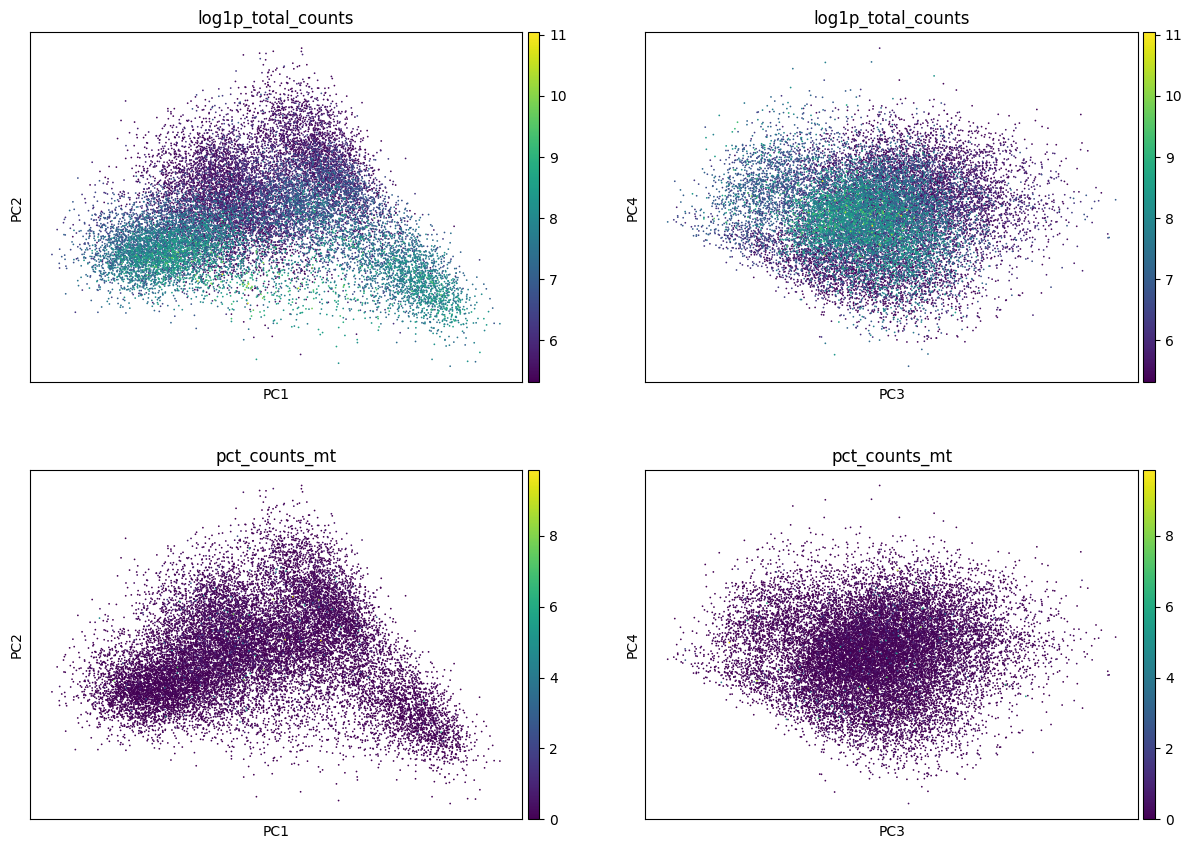

In [186]:
sc.pl.pca(
    sample_2,
    color=["log1p_total_counts"] * 2 + ["pct_counts_mt"] * 2,
    dimensions=[(0, 1), (2, 3)] * 2,
    ncols=2,
    # size=2,
)

In [116]:
sc.pp.neighbors(sample_2, metric='cosine')

In [117]:
sc.tl.umap(sample_2)

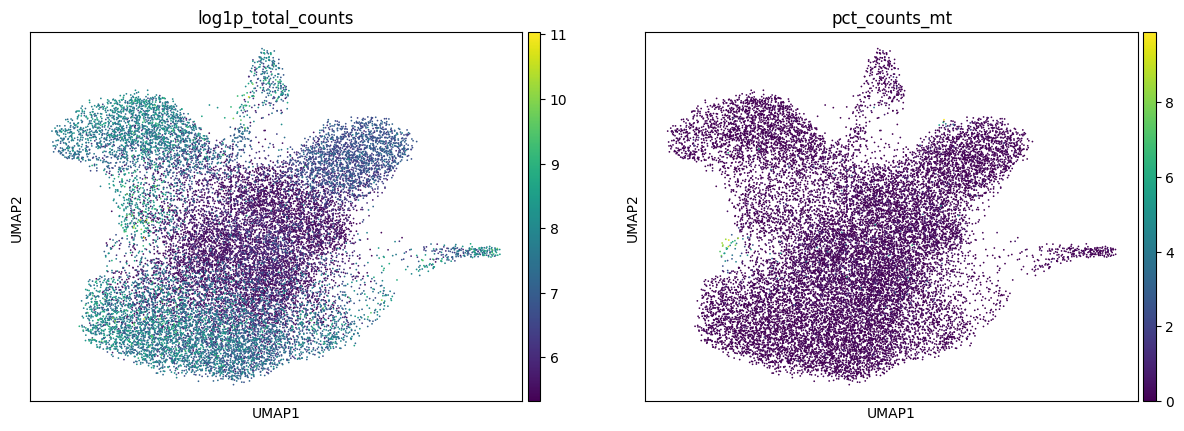

In [36]:
sc.pl.umap(
    sample_2,
    color=["log1p_total_counts", "pct_counts_mt"]
)# Check principal comp.

In [118]:
sc.tl.leiden(sample_2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


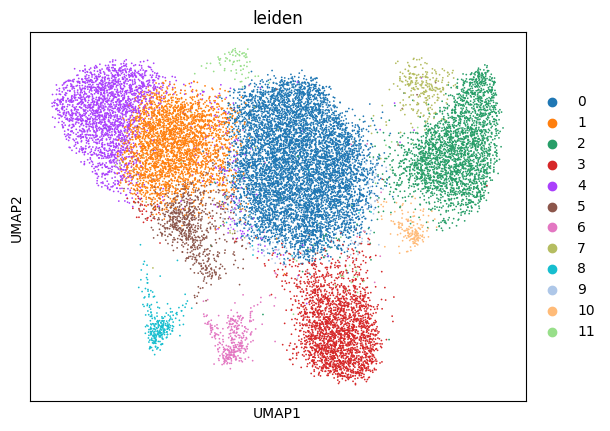

In [119]:
sc.pl.umap(sample_2, color="leiden")

In [192]:
import numpy as np
from scipy.stats import median_abs_deviation

In [193]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [194]:
sample_2.obs["outlier"] = (
    is_outlier(sample_2, "log1p_total_counts", 6)
    | is_outlier(sample_2, "log1p_n_genes_by_counts", 6)
    | is_outlier(sample_2, "pct_counts_in_top_20_genes", 6)
)
sample_2.obs.outlier.value_counts()

outlier
False    19113
True         5
Name: count, dtype: int64

In [195]:
sample_2.obs["mt_outlier"] = is_outlier(sample_2, "pct_counts_mt", 3) | (
    sample_2.obs["pct_counts_mt"] > 8
)
sample_2.obs.mt_outlier.value_counts()

mt_outlier
False    12796
True      6322
Name: count, dtype: int64

In [121]:
df = pd.read_csv('/Users/isabelgiray/Desktop/Annotation_1.csv', delimiter=';')

In [122]:
df

,Merged_barcode,Barcode,Sample_RNA,Sample_ATAC,Case_ID,Piece_ID,Sample_type,data.type.rna,Chemistry,Cancer,cell_type.harmonized.cancer,Aliquot,GEO.sample
0,ccRCC_C3L-00088-T1_AAACCCAAGACGACTG-1,AAACCCAAGACGACTG-1,CPT0000870003-CPT0000870003-lib1,CPT0000870003,C3L-00088,C3L-00088-T1,Tumor,snRNA,snATAC,ccRCC,Tumor,CPT0000870003,C3L-00088-T1_CPT0000870003_snRNA_ccRCC
1,ccRCC_C3L-00088-T1_AAACCCACAAATGATG-1,AAACCCACAAATGATG-1,CPT0000870003-CPT0000870003-lib1,CPT0000870003,C3L-00088,C3L-00088-T1,Tumor,snRNA,snATAC,ccRCC,T-cells,CPT0000870003,C3L-00088-T1_CPT0000870003_snRNA_ccRCC
2,ccRCC_C3L-00088-T1_AAACCCACAATCCAGT-1,AAACCCACAATCCAGT-1,CPT0000870003-CPT0000870003-lib1,CPT0000870003,C3L-00088,C3L-00088-T1,Tumor,snRNA,snATAC,ccRCC,Tumor,CPT0000870003,C3L-00088-T1_CPT0000870003_snRNA_ccRCC
3,ccRCC_C3L-00088-T1_AAACCCACACAATCTG-1,AAACCCACACAATCTG-1,CPT0000870003-CPT0000870003-lib1,CPT0000870003,C3L-00088,C3L-00088-T1,Tumor,snRNA,snATAC,ccRCC,Tumor,CPT0000870003,C3L-00088-T1_CPT0000870003_snRNA_ccRCC
4,ccRCC_C3L-00088-T1_AAACCCACACTCCTTG-1,AAACCCACACTCCTTG-1,CPT0000870003-CPT0000870003-lib1,CPT0000870003,C3L-00088,C3L-00088-T1,Tumor,snRNA,snATAC,ccRCC,Tumor,CPT0000870003,C3L-00088-T1_CPT0000870003_snRNA_ccRCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
416642,GBM_C3N-03186_TTTGTTGAGTCATTGC-1,TTTGTTGAGTCATTGC-1,CPT0206880004-XBn1-1,C3N-03186_CPT0206880004_2020-06-22,C3N-03186,C3N-03186,Tumor,snRNA,snATAC,GBM,Neurons,CPT0206880004,C3N-03186_CPT0206880004_snRNA_GBM
416643,GBM_C3N-03186_TTTGTTGAGTCTCCTC-1,TTTGTTGAGTCTCCTC-1,CPT0206880004-XBn1-1,C3N-03186_CPT0206880004_2020-06-22,C3N-03186,C3N-03186,Tumor,snRNA,snATAC,GBM,Oligodendrocytes,CPT0206880004,C3N-03186_CPT0206880004_snRNA_GBM
416644,GBM_C3N-03186_TTTGTTGCAACTCATG-1,TTTGTTGCAACTCATG-1,CPT0206880004-XBn1-1,C3N-03186_CPT0206880004_2020-06-22,C3N-03186,C3N-03186,Tumor,snRNA,snATAC,GBM,Tumor,CPT0206880004,C3N-03186_CPT0206880004_snRNA_GBM
416645,GBM_C3N-03186_TTTGTTGGTAGCTTTG-1,TTTGTTGGTAGCTTTG-1,CPT0206880004-XBn1-1,C3N-03186_CPT0206880004_2020-06-22,C3N-03186,C3N-03186,Tumor,snRNA,snATAC,GBM,T-cells,CPT0206880004,C3N-03186_CPT0206880004_snRNA_GBM


In [123]:
df_filtered = df[df['GEO.sample'] == 'C3N-00495-T1_CPT0078510004_snRNA_ccRCC']

In [124]:
df_filtered

,Merged_barcode,Barcode,Sample_RNA,Sample_ATAC,Case_ID,Piece_ID,Sample_type,data.type.rna,Chemistry,Cancer,cell_type.harmonized.cancer,Aliquot,GEO.sample
174408,ccRCC_C3N-00495-T1_AAACCCAAGCGTACAG-1,AAACCCAAGCGTACAG-1,CPT0078510004-CPT0078510004-lib1,CPT0078510004,C3N-00495,C3N-00495-T1,Tumor,snRNA,snATAC,ccRCC,Tumor,CPT0078510004,C3N-00495-T1_CPT0078510004_snRNA_ccRCC
174409,ccRCC_C3N-00495-T1_AAACCCAAGGCTGAAC-1,AAACCCAAGGCTGAAC-1,CPT0078510004-CPT0078510004-lib1,CPT0078510004,C3N-00495,C3N-00495-T1,Tumor,snRNA,snATAC,ccRCC,NK,CPT0078510004,C3N-00495-T1_CPT0078510004_snRNA_ccRCC
174410,ccRCC_C3N-00495-T1_AAACCCAAGTAGGCCA-1,AAACCCAAGTAGGCCA-1,CPT0078510004-CPT0078510004-lib1,CPT0078510004,C3N-00495,C3N-00495-T1,Tumor,snRNA,snATAC,ccRCC,Tumor,CPT0078510004,C3N-00495-T1_CPT0078510004_snRNA_ccRCC
174411,ccRCC_C3N-00495-T1_AAACCCAGTACTGGGA-1,AAACCCAGTACTGGGA-1,CPT0078510004-CPT0078510004-lib1,CPT0078510004,C3N-00495,C3N-00495-T1,Tumor,snRNA,snATAC,ccRCC,Tumor,CPT0078510004,C3N-00495-T1_CPT0078510004_snRNA_ccRCC
174412,ccRCC_C3N-00495-T1_AAACCCAGTGACTGTT-1,AAACCCAGTGACTGTT-1,CPT0078510004-CPT0078510004-lib1,CPT0078510004,C3N-00495,C3N-00495-T1,Tumor,snRNA,snATAC,ccRCC,Macrophages,CPT0078510004,C3N-00495-T1_CPT0078510004_snRNA_ccRCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180980,ccRCC_C3N-00495-T1_TTTGTTGCACACCTAA-1,TTTGTTGCACACCTAA-1,CPT0078510004-CPT0078510004-lib1,CPT0078510004,C3N-00495,C3N-00495-T1,Tumor,snRNA,snATAC,ccRCC,Tumor,CPT0078510004,C3N-00495-T1_CPT0078510004_snRNA_ccRCC
180981,ccRCC_C3N-00495-T1_TTTGTTGCAGTGTATC-1,TTTGTTGCAGTGTATC-1,CPT0078510004-CPT0078510004-lib1,CPT0078510004,C3N-00495,C3N-00495-T1,Tumor,snRNA,snATAC,ccRCC,T-cells,CPT0078510004,C3N-00495-T1_CPT0078510004_snRNA_ccRCC
180982,ccRCC_C3N-00495-T1_TTTGTTGGTTGCGGCT-1,TTTGTTGGTTGCGGCT-1,CPT0078510004-CPT0078510004-lib1,CPT0078510004,C3N-00495,C3N-00495-T1,Tumor,snRNA,snATAC,ccRCC,Macrophages,CPT0078510004,C3N-00495-T1_CPT0078510004_snRNA_ccRCC
180983,ccRCC_C3N-00495-T1_TTTGTTGTCCGCGGAT-1,TTTGTTGTCCGCGGAT-1,CPT0078510004-CPT0078510004-lib1,CPT0078510004,C3N-00495,C3N-00495-T1,Tumor,snRNA,snATAC,ccRCC,Macrophages,CPT0078510004,C3N-00495-T1_CPT0078510004_snRNA_ccRCC


In [125]:
annotation = df_filtered[['Barcode','cell_type.harmonized.cancer']]

In [126]:
unique_barcodes = set(sample_2.obs.index) - set(annotation['Barcode'])

In [127]:
unique_barcodes

{'ACTGTCCTCCAGTTCC-1',
 'ACTATCTAGCGATGAC-1',
 'AAAGGATAGTCTCTGA-1',
 'TCATTACCACAAATCC-1',
 'TGATGCAGTGGCCCAT-1',
 'ATGATCGAGATGCGAC-1',
 'GCCAGTGGTATTTCTC-1',
 'TAAGCACTCGAGTCCG-1',
 'AATGCCAAGACATCCT-1',
 'AGGTTACAGCCGTTAT-1',
 'ACATCGATCTCCCATG-1',
 'AGATGAATCACTCCGT-1',
 'ACAGAAACATAGCACT-1',
 'ACCTACCAGTGGATAT-1',
 'GCACATATCGTGGCGT-1',
 'GTGTCCTCACCAGCCA-1',
 'AGTAACCAGGTCATAA-1',
 'CTCCGATGTGGTCTCG-1',
 'TTGCGTCAGTCCCGAC-1',
 'GCCGATGTCCGACAGC-1',
 'TCCTAATCAAGAATAC-1',
 'CTACAGACACTTGACA-1',
 'CTCCGATGTACTAACC-1',
 'AGAGAATCACAGCTTA-1',
 'CAACCAATCCAATGCA-1',
 'CTCAAGACAATACGAA-1',
 'ATGGAGGAGGTATCTC-1',
 'TCAGTGAAGGGCCAAT-1',
 'AGGACTTGTAAGCAAT-1',
 'CGCCATTGTCGTTCAA-1',
 'ACTATGGGTGGTAATA-1',
 'GTAGAAACATGACACT-1',
 'TGTAACGAGGTAGGCT-1',
 'TTGAACGCATGTACGT-1',
 'TTTATGCAGCCTCTCT-1',
 'CACCAAAAGCGTGAAC-1',
 'CCCTCAAGTACTCCGG-1',
 'AACCTTTCAACGCATT-1',
 'ACTTAGGTCGTTCCCA-1',
 'AGCTCAATCCCGTGTT-1',
 'AGGAGGTCAAATCGTC-1',
 'ACAGGGAGTGACTGAG-1',
 'ATACCGACAGACAAAT-1',
 'ATCACTTGT

In [128]:
annotation

,Barcode,cell_type.harmonized.cancer
174408,AAACCCAAGCGTACAG-1,Tumor
174409,AAACCCAAGGCTGAAC-1,NK
174410,AAACCCAAGTAGGCCA-1,Tumor
174411,AAACCCAGTACTGGGA-1,Tumor
174412,AAACCCAGTGACTGTT-1,Macrophages
...,...,...
180980,TTTGTTGCACACCTAA-1,Tumor
180981,TTTGTTGCAGTGTATC-1,T-cells
180982,TTTGTTGGTTGCGGCT-1,Macrophages
180983,TTTGTTGTCCGCGGAT-1,Macrophages


In [129]:
barcodes = annotation['Barcode']

In [130]:
sample_2_filtered = sample_2[sample_2.obs.index.isin(barcodes)].copy()

In [131]:
sample_2_ann = pd.merge(sample_2_filtered.obs, annotation, left_index=True, right_on='Barcode',how='inner')

In [132]:
sample_2_filtered.obs = sample_2_ann.set_index('Barcode')

In [133]:
sample_2_filtered.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,leiden,cell_type.harmonized.cancer
Barcode,,,,,,,,,,,
AAACCCAAGCGTACAG-1,1116,7.018402,1531,7.334329,11.887655,0,0.000000,0.000000,1116,1,Tumor
AAACCCAAGGCTGAAC-1,804,6.690842,1044,6.951772,10.632184,1,0.693147,0.095785,804,3,NK
AAACCCAAGTAGGCCA-1,1988,7.595387,3260,8.089789,8.558282,0,0.000000,0.000000,1988,4,Tumor
AAACCCAGTACTGGGA-1,1186,7.079184,1669,7.420579,9.706411,0,0.000000,0.000000,1186,4,Tumor
AAACCCAGTGACTGTT-1,849,6.745236,1074,6.980076,9.590317,0,0.000000,0.000000,849,2,Macrophages
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACACCTAA-1,904,6.807935,1185,7.078342,11.814346,0,0.000000,0.000000,904,5,Tumor
TTTGTTGCAGTGTATC-1,1025,6.933423,1299,7.170120,6.928406,2,1.098612,0.153965,1025,3,T-cells
TTTGTTGGTTGCGGCT-1,1370,7.223296,1958,7.580189,11.389173,0,0.000000,0.000000,1370,2,Macrophages


In [166]:
Macro = sample_2_filtered.obs[sample_2_filtered.obs['cell_type.harmonized.cancer']=='Macrophages']

In [149]:
Macro

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,leiden,cell_type.harmonized.cancer
Barcode,,,,,,,,,,,
AAACCCAGTGACTGTT-1,849,6.745236,1074,6.980076,9.590317,0,0.000000,0.000000,849,3,Macrophages
AAACCCATCTCCTGAC-1,1012,6.920672,1351,7.209340,11.917098,0,0.000000,0.000000,1012,3,Macrophages
AAACGAAAGACATCAA-1,1820,7.507141,2674,7.891705,9.910247,4,1.609438,0.149589,1820,6,Macrophages
AAACGAATCGTTGTAG-1,1150,7.048386,1573,7.361375,10.743802,0,0.000000,0.000000,1150,3,Macrophages
AAACGCTCAGGACTTT-1,1764,7.475906,2868,7.961719,10.704324,2,1.098612,0.069735,1764,3,Macrophages
...,...,...,...,...,...,...,...,...,...,...,...
TTTGGAGTCGGTGAAG-1,892,6.794587,1151,7.049255,11.120765,0,0.000000,0.000000,892,3,Macrophages
TTTGGTTCACCCGTAG-1,1757,7.471932,2870,7.962416,10.627178,0,0.000000,0.000000,1757,3,Macrophages
TTTGGTTGTATCCCAA-1,1026,6.934397,1359,7.215240,12.067697,1,0.693147,0.073584,1026,3,Macrophages


In [134]:
sample_2_filtered

AnnData object with n_obs × n_vars = 6577 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'cell_type.harmonized.cancer'
    var: 'gene_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


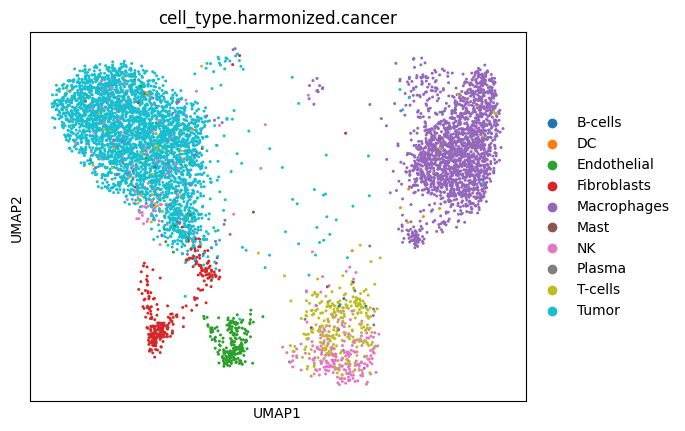

In [135]:
sc.pl.umap(sample_2_filtered,color=['cell_type.harmonized.cancer'])

In [174]:
print(sample_2_filtered.obs.columns)

Index(['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden',
       'outlier', 'mt_outlier', 'cell_type.harmonized.cancer'],
      dtype='object')


In [181]:
sample_2_filtered.obs['outlier'] = sample_2_filtered.obs['outlier'].astype('category')
sample_2_filtered.obs['mt_outlier'] = sample_2_filtered.obs['mt_outlier'].astype('category')

/Users/isabelgiray/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/isabelgiray/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


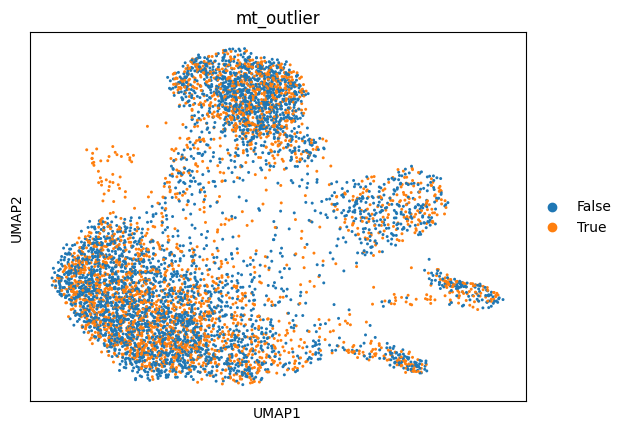

In [182]:
sc.pl.umap(sample_2_filtered,color=['mt_outlier'])

n_genes_by_counts = number of unique genes that have at least one read detected in a single cell.

In [136]:
sample_2_filtered.var.sort_values(by='n_cells_by_counts', ascending=False)

,gene_id,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
MALAT1,ENSG00000251562,False,108232,0.962332,0.674133,88.495602,905350,13.716078,19064,True,2.783989,1.059515,1.000000
UBE2D2,ENSG00000131508,False,58372,0.258238,0.229712,93.795414,242947,12.400603,14913,True,1.623303,1.743569,1.000000
NEAT1,ENSG00000245532,False,52751,0.170321,0.157278,94.392892,160236,11.984409,15482,True,1.301683,0.950968,1.000000
VEGFA,ENSG00000112715,False,39593,0.079032,0.076064,95.791507,74352,11.216579,12330,True,0.885169,0.755541,1.000000
SAT1,ENSG00000130066,False,30106,0.053681,0.052289,96.799917,50502,10.829788,10018,True,0.674001,0.773189,1.165376
...,...,...,...,...,...,...,...,...,...,...,...,...,...
LINC02616,ENSG00000261761,False,3,0.000003,0.000003,99.999681,3,1.386294,3,True,0.000229,0.773612,1.165844
AP001627.1,ENSG00000225731,False,3,0.000003,0.000003,99.999681,3,1.386294,3,True,0.000173,0.984688,1.604676
LINC00559,ENSG00000261446,False,3,0.000003,0.000003,99.999681,3,1.386294,3,True,0.000255,0.884472,1.396325
AC109349.1,ENSG00000248176,False,3,0.000003,0.000003,99.999681,3,1.386294,3,True,0.000223,0.781258,1.181741


In [137]:
sample_2_filtered.obs.sort_values(by='n_genes_by_counts', ascending=False)

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,leiden,cell_type.harmonized.cancer
Barcode,,,,,,,,,,,
CCTTGTGCACTCATAG-1,6852,8.832442,22199,10.007848,6.806613,2,1.098612,0.009009,6852,6,Endothelial
ACCACAATCTTCTAAC-1,6178,8.728912,23571,10.067815,9.019558,4,1.609438,0.016970,6178,5,Fibroblasts
AAAGGGCGTGCCGAAA-1,5707,8.649624,14576,9.587200,6.256861,1,0.693147,0.006861,5707,6,Endothelial
GGGCTCAAGGCTCAAG-1,5687,8.646114,18647,9.833494,8.666273,1,0.693147,0.005363,5687,6,Endothelial
TCATTGTAGGTGAGAA-1,5068,8.530899,12837,9.460165,8.366441,6,1.945910,0.046740,5068,8,Fibroblasts
...,...,...,...,...,...,...,...,...,...,...,...
TTCCACGCAGCTGAGA-1,754,6.626718,1028,6.936343,11.284047,0,0.000000,0.000000,754,3,T-cells
TACTTCAAGTCCCTAA-1,750,6.621406,1004,6.912743,13.047809,1,0.693147,0.099602,750,2,Macrophages
TGAATCGCATCCTGTC-1,727,6.590301,1009,6.917706,14.271556,1,0.693147,0.099108,727,2,Macrophages


In [151]:
sample_2_filtered.var_names[sample_2_filtered.var_names.duplicated()]

Index([], dtype='object')

In [150]:
gene_id = sample_2_filtered.var_names.get_loc('MALAT1')
cell_id = sample_2_filtered.obs_names.get_loc('CCTTGTGCACTCATAG-1')

AttributeError: 'DataFrame' object has no attribute 'get_loc'

In [149]:
sample_2_filtered[cell_id,gene_id].X.todense()

matrix([[2.7863586]], dtype=float32)